2024-04-15 00:35:23,695 [torchrl][INFO] check_env_specs succeeded!


action_spec: CompositeSpec(
    agents: CompositeSpec(
        action: BoundedTensorSpec(
            shape=torch.Size([60, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous), device=cpu, shape=torch.Size([60, 3])), device=cpu, shape=torch.Size([60]))
reward_spec: CompositeSpec(
    agents: CompositeSpec(
        reward: UnboundedContinuousTensorSpec(
            shape=torch.Size([60, 3, 1]),
            space=None,
            device=cpu,
            dtype=torch.float32,
            domain=continuous), device=cpu, shape=torch.Size([60, 3])), device=cpu, shape=torch.Size([60]))
done_spec: CompositeSpec(
    done: DiscreteTensorSpec(
        shape=torch.Size([60, 1]),
        space=DiscreteBox(n=

episode_reward_mean = 0.10111597925424576: 100%|██████████| 10/10 [00:34<00:00,  3.71s/it]

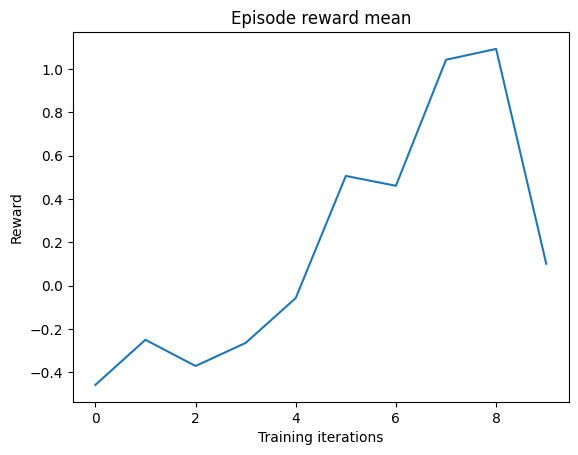

KeyboardInterrupt: 

In [2]:
# Torch
import torch

from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor

# Tensordict modules
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

import os
import PIL.Image as PILImage


# Add this import at the top of your script
import io
import numpy as np

from IPython.display import display, Image



# Modify the rendering callback function
def rendering_callback(env, td):
    frame = env.render(mode="rgb_array")
    env.frames.append(frame)

def main():
    # Sampling
    frames_per_batch = 6_000  # Number of team frames collected per training iteration
    n_iters = 10  # Number of sampling and training iterations
    total_frames = frames_per_batch * n_iters

    # Training
    num_epochs = 1  # Number of optimization steps per training iteration
    minibatch_size = 400  # Size of the mini-batches in each optimization step
    lr = 0.0003  # Learning rate
    max_grad_norm = 1.0  # Maximum norm for the gradients

    # PPO
    clip_epsilon = 0.2  # clip value for PPO loss
    gamma = 0.9  # discount factor
    lmbda = 0.9  # lambda for generalised advantage estimation
    entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

    max_steps = 100  # Episode steps before done
    num_vmas_envs = (
        frames_per_batch // max_steps
    )  # Number of vectorized envs. frames_per_batch should be divisible by this number
    scenario_name = "navigation"
    n_agents = 3

    env = VmasEnv(
        scenario=scenario_name,
        num_envs=num_vmas_envs,
        continuous_actions=True,  # VMAS supports both continuous and discrete actions
        max_steps=max_steps,
        device=vmas_device,
        # Scenario kwargs
        n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
    )

    print("action_spec:", env.full_action_spec)
    print("reward_spec:", env.full_reward_spec)
    print("done_spec:", env.full_done_spec)
    print("observation_spec:", env.observation_spec)

    print("action_keys:", env.action_keys)
    print("reward_keys:", env.reward_keys)
    print("done_keys:", env.done_keys)

    env = TransformedEnv(
        env,
        RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
    )

    check_env_specs(env)

    n_rollout_steps = 5
    rollout = env.rollout(n_rollout_steps)
    print("rollout of three steps:", rollout)
    print("Shape of the rollout TensorDict:", rollout.batch_size)


    share_parameters_policy = True

    policy_net = torch.nn.Sequential(
        MultiAgentMLP(
            n_agent_inputs=env.observation_spec["agents", "observation"].shape[
                -1
            ],  # n_obs_per_agent
            n_agent_outputs=2 * env.action_spec.shape[-1],  # 2 * n_actions_per_agents
            n_agents=env.n_agents,
            centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
            share_params=share_parameters_policy,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
    )

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[("agents", "observation")],
        out_keys=[("agents", "loc"), ("agents", "scale")],
    )


    policy = ProbabilisticActor(
        module=policy_module,
        spec=env.unbatched_action_spec,
        in_keys=[("agents", "loc"), ("agents", "scale")],
        out_keys=[env.action_key],
        distribution_class=TanhNormal,
        distribution_kwargs={
            "min": env.unbatched_action_spec[env.action_key].space.low,
            "max": env.unbatched_action_spec[env.action_key].space.high,
        },
        return_log_prob=True,
        log_prob_key=("agents", "sample_log_prob"),
    )  # we'll need the log-prob for the PPO loss

    share_parameters_critic = True
    mappo = True  # IPPO if False

    critic_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs=1,  # 1 value per agent
        n_agents=env.n_agents,
        centralised=mappo,
        share_params=share_parameters_critic,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    critic = TensorDictModule(
        module=critic_net,
        in_keys=[("agents", "observation")],
        out_keys=[("agents", "state_value")],
    )


    print("Running policy:", policy(env.reset()))
    print("Running value:", critic(env.reset()))

    collector = SyncDataCollector(
        env,
        policy,
        device=vmas_device,
        storing_device=device,
        frames_per_batch=frames_per_batch,
        total_frames=total_frames,
    )

    replay_buffer = ReplayBuffer(
        storage=LazyTensorStorage(
            frames_per_batch, device=device
        ),  # We store the frames_per_batch collected at each iteration
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,  # We will sample minibatches of this size
    )

    loss_module = ClipPPOLoss(
        actor_network=policy,
        critic_network=critic,
        clip_epsilon=clip_epsilon,
        entropy_coef=entropy_eps,
        normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
    )
    loss_module.set_keys(  # We have to tell the loss where to find the keys
        reward=env.reward_key,
        action=env.action_key,
        sample_log_prob=("agents", "sample_log_prob"),
        value=("agents", "state_value"),
        # These last 2 keys will be expanded to match the reward shape
        done=("agents", "done"),
        terminated=("agents", "terminated"),
    )


    loss_module.make_value_estimator(
        ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
    )  # We build GAE

    GAE = loss_module.value_estimator

    optim = torch.optim.Adam(loss_module.parameters(), lr)

    pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

    episode_reward_mean_list = []
    for tensordict_data in collector:
        tensordict_data.set(
            ("next", "agents", "done"),
            tensordict_data.get(("next", "done"))
            .unsqueeze(-1)
            .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
        )
        tensordict_data.set(
            ("next", "agents", "terminated"),
            tensordict_data.get(("next", "terminated"))
            .unsqueeze(-1)
            .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
        )
        # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)

        with torch.no_grad():
            GAE(
                tensordict_data,
                params=loss_module.critic_network_params,
                target_params=loss_module.target_critic_network_params,
            )  # Compute GAE and add it to the data

        data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
        replay_buffer.extend(data_view)

        for _ in range(num_epochs):
            for _ in range(frames_per_batch // minibatch_size):
                subdata = replay_buffer.sample()
                loss_vals = loss_module(subdata)

                loss_value = (
                    loss_vals["loss_objective"]
                    + loss_vals["loss_critic"]
                    + loss_vals["loss_entropy"]
                )

                loss_value.backward()

                torch.nn.utils.clip_grad_norm_(
                    loss_module.parameters(), max_grad_norm
                )  # Optional

                optim.step()
                optim.zero_grad()

        collector.update_policy_weights_()

        # Logging
        done = tensordict_data.get(("next", "agents", "done"))
        episode_reward_mean = (
            tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
        )
        episode_reward_mean_list.append(episode_reward_mean)
        pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
        pbar.update()


    plt.plot(episode_reward_mean_list)
    plt.xlabel("Training iterations")
    plt.ylabel("Reward")
    plt.title("Episode reward mean")
    plt.show()

    env.frames = []

    with torch.no_grad():
        env.rollout(
            max_steps=max_steps,
            policy=policy,
            callback=rendering_callback,
            auto_cast_to_device=True,
            break_when_any_done=False,
        )

    # Convert frames to PIL Image objects if necessary
    env.frames = [PILImage.fromarray(frame) if isinstance(frame, np.ndarray) else frame for frame in env.frames]


    # Generate GIF from captured frames
    gif_path = f"{scenario_name}.gif"
    # display(Image(gif_path))
    
    # Create GIF from frames
    frames = env.frames
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=300,  # Duration between frames in milliseconds
        loop=0,  # 0 means loop indefinitely
    )

    display(Image(gif_path))

if __name__ == "__main__":
    main()
